# XGBoost 模型训练

本 Notebook 用于训练和评估 XGBoost 分类模型，用于预测加密货币价格变动。

In [1]:
!pip install matplotlib seaborn
import sys
import os

# 添加项目路径
sys.path.insert(0, os.path.abspath('../src'))

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置绘图样式
sns.set_style("whitegrid")

print("环境初始化完成")

Looking in indexes: https://pypi.org/simple/

[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: pip install --upgrade pip
环境初始化完成


## 1. 数据加载和探索

In [3]:
from collect.feature_handler import feature_handler
from config.settings import config

# 配置参数
INST_ID = "ETH-USDT-SWAP"
BAR = "1H"
LIMIT = 20000

# 从 MongoDB 加载特征数据
print(f"从 MongoDB 加载特征数据...")
print(f"  inst_id: {INST_ID}")
print(f"  bar: {BAR}")
print(f"  limit: {LIMIT}")

features = feature_handler.get_features(
    limit=LIMIT, 
    inst_id=INST_ID, 
    bar=BAR
)

print(f"\n加载完成，共 {len(features)} 条记录")

2026-02-05 19:02:33,794 - collect.mongodb_base - INFO - Connected to MongoDB at mongodb://localhost:27017
2026-02-05 19:02:33,795 - collect.mongodb_base - INFO - Database: technical_analysis
2026-02-05 19:02:33,797 - collect.mongodb_base - INFO - Created index: idx_timestamp on fields ['timestamp']
2026-02-05 19:02:33,798 - collect.mongodb_base - INFO - Created index: idx_inst_id on fields ['inst_id']
2026-02-05 19:02:33,799 - collect.mongodb_base - INFO - Created index: idx_bar on fields ['bar']
2026-02-05 19:02:33,799 - collect.mongodb_base - INFO - Cleaning up duplicates for fields ['inst_id', 'timestamp', 'bar']
2026-02-05 19:02:33,964 - collect.mongodb_base - INFO - No duplicates found for fields ['inst_id', 'timestamp', 'bar']
2026-02-05 19:02:33,965 - collect.mongodb_base - INFO - Created unique index: unique_inst_id_timestamp_bar on fields ['inst_id', 'timestamp', 'bar']


从 MongoDB 加载特征数据...
  inst_id: ETH-USDT-SWAP
  bar: 1H
  limit: 20000

加载完成，共 13266 条记录


In [4]:
# 转换为 DataFrame
df = pd.DataFrame(features)

print("数据形状:", df.shape)
print("\n数据类型:")
print(df.dtypes)

数据形状: (13266, 41)

数据类型:
_id                       object
close_1h_normalized      float64
volume_1h_normalized     float64
rsi_14_1h                float64
macd_line_1h             float64
macd_signal_1h           float64
macd_histogram_1h        float64
hour_cos                 float64
hour_sin                 float64
day_of_week                int64
rsi_14_15m               float64
volume_impulse_15m       float64
macd_line_15m            float64
macd_signal_15m          float64
macd_histogram_15m       float64
atr_15m                  float64
stoch_k_15m              float64
stoch_d_15m              float64
rsi_14_4h                float64
trend_continuation_4h    float64
macd_line_4h             float64
macd_signal_4h           float64
macd_histogram_4h        float64
atr_4h                   float64
adx_4h                   float64
plus_di_4h               float64
minus_di_4h              float64
ema_12_4h                float64
ema_26_4h                float64
ema_48_4h         

In [ ]:
# 查看前几条数据
print("前 5 条数据:")
df.head()

In [5]:
# 检查缺失值
print("缺失值统计:")
print(df.isnull().sum()[df.isnull().sum() > 0])

缺失值统计:
Series([], dtype: int64)


标签分布:
label
1    4250
2    4706
3    4310
Name: count, dtype: int64


/Users/anthony/Documents/github/technial_analysis_helper/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anthony/Documents/github/technial_analysis_helper/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anthony/Documents/github/technial_analysis_helper/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anthony/Documents/github/technial_analysis_helper/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io

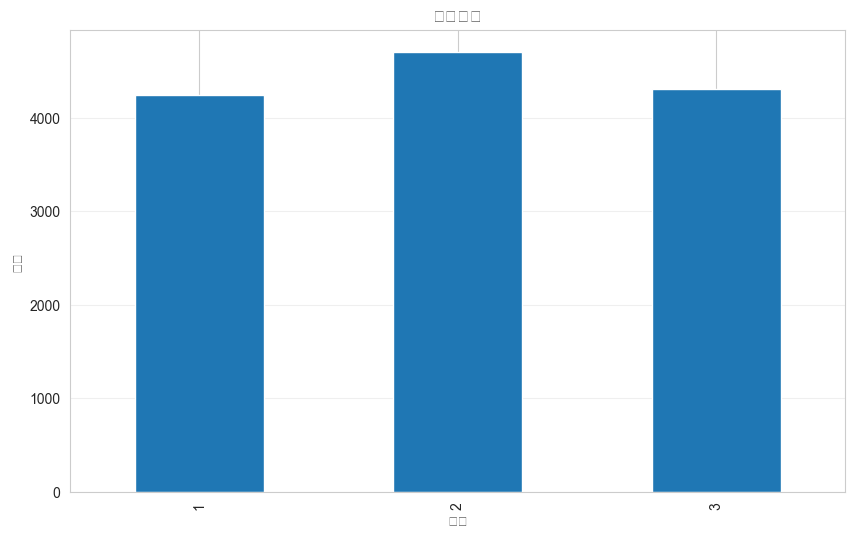

In [6]:
# 检查标签分布
if 'label' in df.columns:
    label_counts = df['label'].value_counts().sort_index()
    print("标签分布:")
    print(label_counts)
    
    # 绘制标签分布图
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar')
    plt.title('标签分布')
    plt.xlabel('标签')
    plt.ylabel('数量')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print("警告：数据中没有 'label' 字段")

In [7]:
# 统计信息
print("数值特征统计:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe()

数值特征统计:


,close_1h_normalized,volume_1h_normalized,rsi_14_1h,macd_line_1h,macd_signal_1h,macd_histogram_1h,hour_cos,hour_sin,day_of_week,rsi_14_15m,...,ema_48_4h,ema_cross_4h_12_26,ema_cross_4h_26_48,rsi_14_1d,atr_1d,bollinger_upper_1d,bollinger_lower_1d,bollinger_position_1d,timestamp,label
count,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,...,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,13266.000000,1.326600e+04,13266.000000
mean,7.402235,-0.196872,50.639605,-1.122720,-1.069124,-0.048636,-0.000249,0.000324,3.000905,50.362129,...,7.414911,-0.024273,-0.015830,49.403437,164.165536,8.709916,6.143331,0.483220,1.746232e+12,2.004523
std,2.160390,0.180718,17.141802,52.221179,49.715986,12.178708,0.707147,0.707093,2.000075,15.772536,...,2.121971,0.997327,0.998403,17.725385,41.169614,2.360083,1.982232,0.263213,1.378695e+10,0.803297
min,2.869000,-0.360000,1.000000,-298.000000,-268.000000,-83.367000,-1.000000,-1.000000,0.000000,1.000000,...,3.312000,-1.000000,-1.000000,10.000000,88.000000,4.108000,2.310000,0.000000,1.722355e+12,1.000000
25%,5.951000,-0.301000,39.000000,-25.000000,-25.000000,-5.889500,-0.707100,-0.707100,1.000000,39.000000,...,6.027000,-1.000000,-1.000000,35.000000,129.000000,6.869000,4.876000,0.290000,1.734294e+12,1.000000
50%,7.193500,-0.251500,51.000000,1.000000,1.000000,0.133000,0.000000,0.000000,3.000000,50.000000,...,7.229000,-1.000000,-1.000000,48.000000,168.000000,8.535000,5.825000,0.440000,1.746232e+12,2.000000
75%,8.754750,-0.163000,63.000000,25.000000,24.000000,5.897250,0.707100,0.707100,5.000000,61.000000,...,8.809000,1.000000,1.000000,63.000000,192.000000,10.634000,7.352000,0.690000,1.758171e+12,3.000000
max,12.867000,2.657000,98.000000,252.000000,219.000000,95.530000,1.000000,1.000000,6.000000,99.000000,...,11.798000,1.000000,1.000000,96.000000,257.000000,13.508000,10.608000,1.000000,1.770109e+12,3.000000


## 2. 模型训练

In [8]:
!pip install joblib xgboost scikit-learn
from models.xgboost_trainer import xgb_trainer

print("开始训练 XGBoost 模型...")
print(f"训练时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# 训练模型
results = xgb_trainer.train_model(
    inst_id=INST_ID,
    bar=BAR,
    limit=LIMIT,
    test_size=0.2,
    cv_folds=5,
    use_class_weight=True
)

print(f"\n训练完成！")

Looking in indexes: https://pypi.org/simple/

[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: pip install --upgrade pip


2026-02-05 19:02:57,099 - models.xgboost_trainer - INFO - Starting XGBoost model training
2026-02-05 19:02:57,289 - models.xgboost_trainer - INFO - Retrieved 13266 features from MongoDB


开始训练 XGBoost 模型...
训练时间: 2026-02-05 19:02:57


2026-02-05 19:02:57,440 - models.xgboost_trainer - INFO - Prepared training data: 13266 samples, 36 features
2026-02-05 19:02:57,441 - models.xgboost_trainer - INFO - Feature columns: ['close_1h_normalized', 'volume_1h_normalized', 'rsi_14_1h', 'macd_line_1h', 'macd_signal_1h', 'macd_histogram_1h', 'hour_cos', 'hour_sin', 'day_of_week', 'rsi_14_15m', 'volume_impulse_15m', 'macd_line_15m', 'macd_signal_15m', 'macd_histogram_15m', 'atr_15m', 'stoch_k_15m', 'stoch_d_15m', 'rsi_14_4h', 'trend_continuation_4h', 'macd_line_4h', 'macd_signal_4h', 'macd_histogram_4h', 'atr_4h', 'adx_4h', 'plus_di_4h', 'minus_di_4h', 'ema_12_4h', 'ema_26_4h', 'ema_48_4h', 'ema_cross_4h_12_26', 'ema_cross_4h_26_48', 'rsi_14_1d', 'atr_1d', 'bollinger_upper_1d', 'bollinger_lower_1d', 'bollinger_position_1d']
2026-02-05 19:02:57,444 - models.xgboost_trainer - INFO - Label distribution:
label
0    4250
1    4706
2    4310
Name: count, dtype: int64
2026-02-05 19:02:57,448 - models.xgboost_trainer - INFO - Number of f


训练完成！


## 3. 训练结果分析

In [9]:
# 打印训练结果
print("="*60)
print("训练结果摘要")
print("="*60)
print(f"准确率: {results['accuracy']:.4f}")
print(f"交叉验证准确率: {results['cv_mean_accuracy']:.4f} (+/- {results['cv_std_accuracy']*2:.4f})")
print(f"训练时间: {results['trained_at']}")

训练结果摘要
准确率: 0.8497
交叉验证准确率: 0.8281 (+/- 0.0169)
训练时间: 2026-02-05T19:03:09.847009


In [10]:
# 每个类别的置信度
print("\n各类别置信度:")
for label, confidence in results['class_confidence'].items():
    print(f"  类别 {label}: {confidence:.4f}")


各类别置信度:
  类别 1: 0.7896
  类别 2: 0.6610
  类别 3: 0.7834


/Users/anthony/Documents/github/technial_analysis_helper/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anthony/Documents/github/technial_analysis_helper/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anthony/Documents/github/technial_analysis_helper/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anthony/Documents/github/technial_analysis_helper/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io

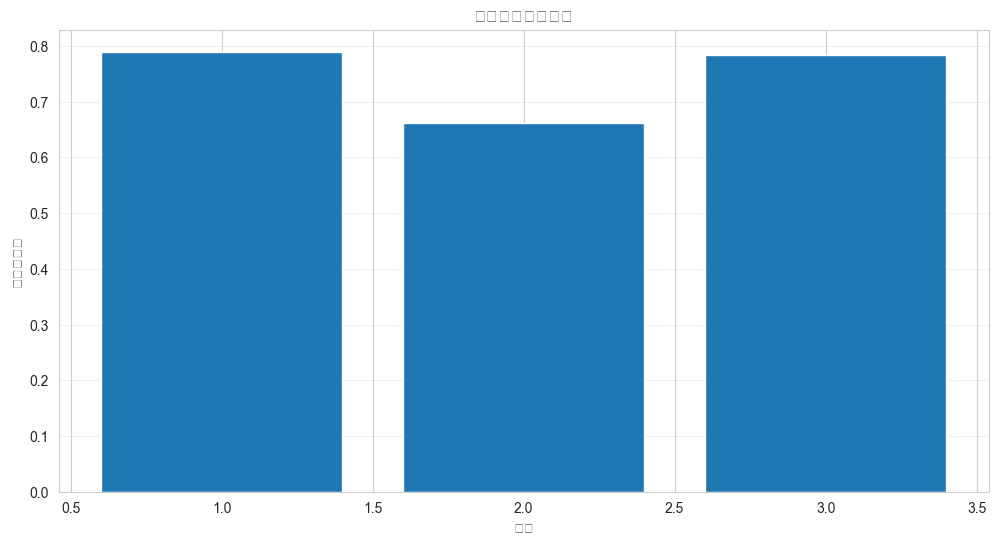

In [11]:
# 绘制各类别置信度
plt.figure(figsize=(12, 6))
labels = list(results['class_confidence'].keys())
confidences = list(results['class_confidence'].values())
plt.bar(labels, confidences)
plt.xlabel('类别')
plt.ylabel('平均置信度')
plt.title('各类别平均置信度')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [12]:
# 打印详细的分类报告
print("\n详细分类报告:")
print("="*60)
class_report = results['classification_report']
for label in sorted(class_report.keys()):
    if label == 'accuracy' or label == 'macro avg' or label == 'weighted avg':
        print(f"\n{label}: {class_report[label]}")
    else:
        print(f"\n类别 {label}:")
        for metric, value in class_report[label].items():
            print(f"  {metric}: {value:.4f}")


详细分类报告:

类别 1:
  precision: 0.8656
  recall: 0.8941
  f1-score: 0.8796
  support: 850.0000

类别 2:
  precision: 0.8000
  recall: 0.7813
  f1-score: 0.7905
  support: 942.0000

类别 3:
  precision: 0.8867
  recall: 0.8805
  f1-score: 0.8836
  support: 862.0000

accuracy: 0.8496608892238131

macro avg: {'precision': 0.8507619625458597, 'recall': 0.8519814786964733, 'f1-score': 0.8512543307687453, 'support': 2654.0}

weighted avg: {'precision': 0.8491647292418351, 'recall': 0.8496608892238131, 'f1-score': 0.8492961445583074, 'support': 2654.0}


## 4. 特征重要性分析

In [13]:
# 获取特征重要性
importance = xgb_trainer.model.get_score(importance_type='gain')

# 转换为 DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})
importance_df = importance_df.sort_values('importance', ascending=False)

print("特征重要性 Top 20:")
print(importance_df.head(20))

特征重要性 Top 20:
   feature  importance
35     f35    4.510117
8       f8    3.780634
31     f31    3.459179
34     f34    3.364948
19     f19    3.337129
28     f28    3.232294
20     f20    3.151993
32     f32    3.136538
26     f26    3.119092
29     f29    3.092129
30     f30    3.073644
33     f33    3.007742
27     f27    2.992422
0       f0    2.688835
3       f3    2.678641
22     f22    2.516453
23     f23    2.504258
18     f18    2.239665
24     f24    2.222494
21     f21    2.204865


/var/folders/1c/y97rt5qx36dgdtfktjgbv3qw0000gn/T/ipykernel_36980/47584730.py:8: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1c/y97rt5qx36dgdtfktjgbv3qw0000gn/T/ipykernel_36980/47584730.py:8: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1c/y97rt5qx36dgdtfktjgbv3qw0000gn/T/ipykernel_36980/47584730.py:8: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1c/y97rt5qx36dgdtfktjgbv3qw0000gn/T/ipykernel_36980/47584730.py:8: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1c/y97rt5qx36dgdtfktjgbv3qw0000gn/T/ipykernel_36980/47584730.py:8: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  plt.tight_layout()
/Users/anthony/Documents/github/technial_analysis_helper/.venv/li

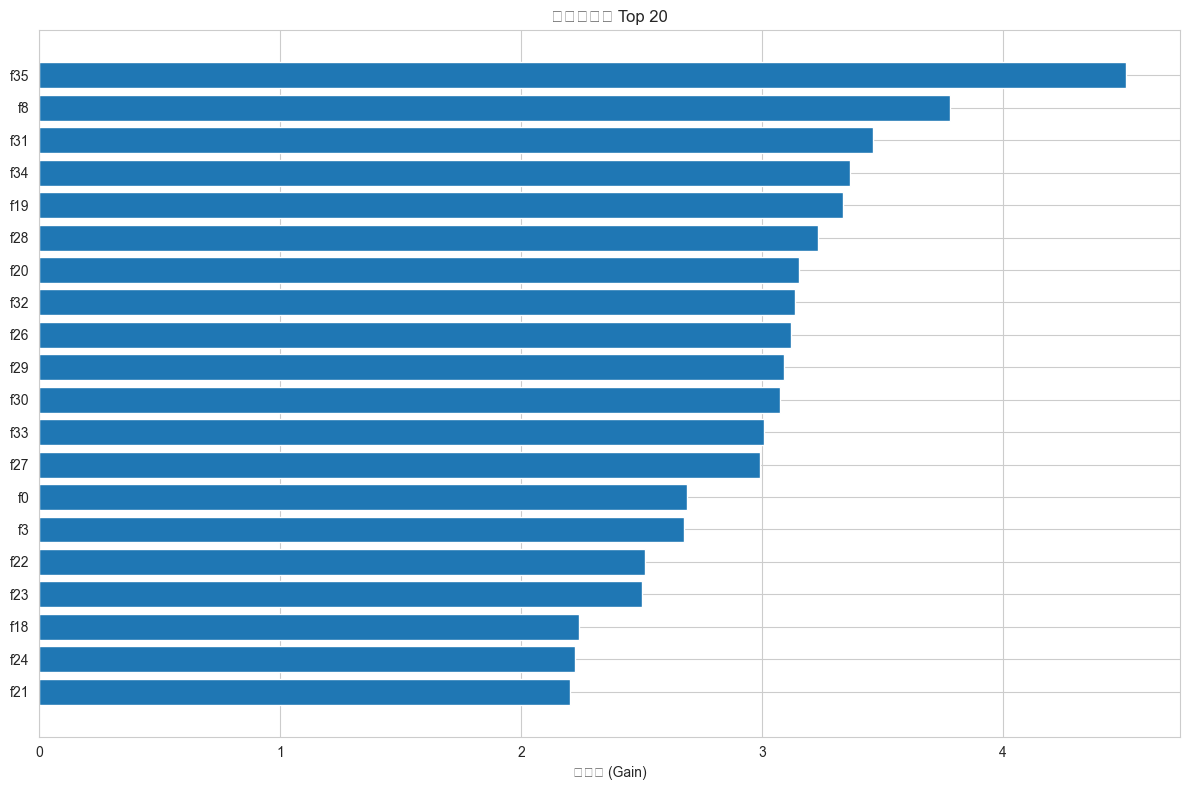

In [14]:
# 绘制特征重要性
plt.figure(figsize=(12, 8))
top_n = 20
plt.barh(range(top_n), importance_df['importance'].head(top_n)[::-1])
plt.yticks(range(top_n), importance_df['feature'].head(top_n)[::-1])
plt.xlabel('重要性 (Gain)')
plt.title(f'特征重要性 Top {top_n}')
plt.tight_layout()
plt.show()

## 5. 模型预测测试

In [15]:
# 加载一些新数据进行预测
test_features = feature_handler.get_features(limit=5, inst_id=INST_ID, bar=BAR)

if test_features:
    print(f"测试预测，使用 {len(test_features)} 条新数据...")
    
    predictions, probabilities = xgb_trainer.predict(test_features)
    
    print("\n预测结果:")
    for i, (pred, prob, feature) in enumerate(zip(predictions, probabilities, test_features)):
        timestamp = feature.get('timestamp', 'N/A')
        actual_label = feature.get('label', 'N/A')
        print(f"\n样本 {i+1}:")
        print(f"  时间戳: {timestamp}")
        print(f"  实际标签: {actual_label}")
        print(f"  预测标签: {pred}")
        print(f"  预测概率: {prob}")
        print(f"  最高概率类别: {np.argmax(prob) + 1} (置信度: {np.max(prob):.4f})")

测试预测，使用 5 条新数据...

预测结果:

样本 1:
  时间戳: 1770109200000
  实际标签: 1
  预测标签: 1
  预测概率: [0.8625353  0.03623148 0.1012332 ]
  最高概率类别: 1 (置信度: 0.8625)

样本 2:
  时间戳: 1770105600000
  实际标签: 1
  预测标签: 1
  预测概率: [0.90853083 0.02053811 0.07093108]
  最高概率类别: 1 (置信度: 0.9085)

样本 3:
  时间戳: 1770102000000
  实际标签: 1
  预测标签: 1
  预测概率: [0.9335788  0.01744471 0.04897647]
  最高概率类别: 1 (置信度: 0.9336)

样本 4:
  时间戳: 1770098400000
  实际标签: 1
  预测标签: 1
  预测概率: [0.9224171  0.02189593 0.05568698]
  最高概率类别: 1 (置信度: 0.9224)

样本 5:
  时间戳: 1770094800000
  实际标签: 1
  预测标签: 1
  预测概率: [0.9371991  0.02216169 0.04063917]
  最高概率类别: 1 (置信度: 0.9372)


## 6. 模型保存信息

In [16]:
print("模型保存位置:")
print(f"  模型文件: {config.MODEL_SAVE_PATH}")
print(f"  Scaler 文件: {config.MODEL_SAVE_PATH.replace('.json', '_scaler.pkl')}")
print(f"  特征列文件: {config.MODEL_SAVE_PATH.replace('.json', '_features.json')}")
print(f"\n使用的特征列 ({len(xgb_trainer.feature_columns)} 个):")
for i, col in enumerate(xgb_trainer.feature_columns, 1):
    print(f"  {i}. {col}")

模型保存位置:
  模型文件: models/xgboost_model.json
  Scaler 文件: models/xgboost_model_scaler.pkl
  特征列文件: models/xgboost_model_features.json

使用的特征列 (36 个):
  1. close_1h_normalized
  2. volume_1h_normalized
  3. rsi_14_1h
  4. macd_line_1h
  5. macd_signal_1h
  6. macd_histogram_1h
  7. hour_cos
  8. hour_sin
  9. day_of_week
  10. rsi_14_15m
  11. volume_impulse_15m
  12. macd_line_15m
  13. macd_signal_15m
  14. macd_histogram_15m
  15. atr_15m
  16. stoch_k_15m
  17. stoch_d_15m
  18. rsi_14_4h
  19. trend_continuation_4h
  20. macd_line_4h
  21. macd_signal_4h
  22. macd_histogram_4h
  23. atr_4h
  24. adx_4h
  25. plus_di_4h
  26. minus_di_4h
  27. ema_12_4h
  28. ema_26_4h
  29. ema_48_4h
  30. ema_cross_4h_12_26
  31. ema_cross_4h_26_48
  32. rsi_14_1d
  33. atr_1d
  34. bollinger_upper_1d
  35. bollinger_lower_1d
  36. bollinger_position_1d


## 7. 参数调优建议

In [17]:
# 基于当前结果，给出参数调优建议
print("\n参数调优建议:")
print("="*60)

# 分析类别不平衡
if 'label' in df.columns:
    label_counts = df['label'].value_counts()
    min_count = label_counts.min()
    max_count = label_counts.max()
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    if imbalance_ratio > 5:
        print(f"⚠️ 类别不平衡严重 (比例: {imbalance_ratio:.2f})")
        print("   建议: 使用 class_weight 或 SMOTE 进行平衡")

# 分析模型性能
if results['accuracy'] < 0.7:
    print("⚠️ 模型准确率较低")
    print("   建议: 检查特征质量，考虑增加更多特征")
elif results['accuracy'] > 0.9:
    print("✅ 模型准确率很高")
    print("   注意: 检查是否存在过拟合，考虑使用更多验证数据")

# 分析交叉验证稳定性
cv_std = results['cv_std_accuracy']
if cv_std > 0.05:
    print(f"⚠️ 交叉验证标准差较高 ({cv_std:.4f})")
    print("   建议: 模型稳定性有待提高，考虑调整超参数")

# 分析特征重要性
if len(importance_df) > 0:
    top_features = importance_df.head(5)['feature'].tolist()
    print("\n最重要的 5 个特征:")
    for i, feat in enumerate(top_features, 1):
        print(f"  {i}. {feat}")


参数调优建议:

最重要的 5 个特征:
  1. f35
  2. f8
  3. f31
  4. f34
  5. f19
